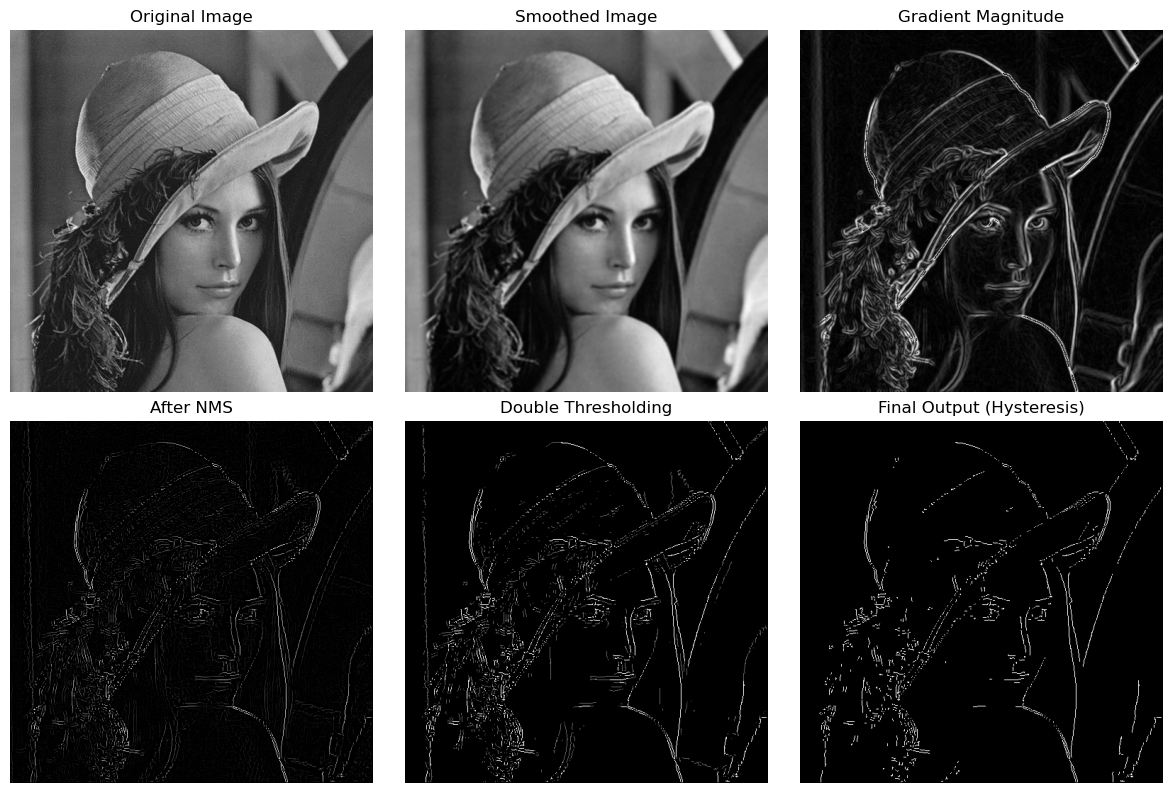

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
lena_path = os.path.join(os.getcwd(), 'data', 'images', 'lena_color.jpg')
image = cv2.imread(lena_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Original Image
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")
plt.axis("off")

# Step 2: Smoothing (Gaussian Blur)
blurred_image = cv2.GaussianBlur(image, (5, 5), 1.4)
plt.subplot(2, 3, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Smoothed Image")
plt.axis("off")

# Step 3: Gradient Magnitudes and Direction
sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
gradient_magnitude = np.uint8(gradient_magnitude)
gradient_direction = np.arctan2(sobel_y, sobel_x)

plt.subplot(2, 3, 3)
plt.imshow(gradient_magnitude, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")

# Step 4: Non-Maximum Suppression
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    nms_image = np.zeros_like(gradient_magnitude)
    angle = gradient_direction * (180 / np.pi)
    angle[angle < 0] += 180

    for y in range(1, gradient_magnitude.shape[0] - 1):
        for x in range(1, gradient_magnitude.shape[1] - 1):
            q = r = 255

            # Determine the direction of the gradient
            if (0 <= angle[y, x] < 22.5) or (157.5 <= angle[y, x] <= 180):
                q = gradient_magnitude[y, x + 1]
                r = gradient_magnitude[y, x - 1]
            elif 22.5 <= angle[y, x] < 67.5:
                q = gradient_magnitude[y + 1, x - 1]
                r = gradient_magnitude[y - 1, x + 1]
            elif 67.5 <= angle[y, x] < 112.5:
                q = gradient_magnitude[y + 1, x]
                r = gradient_magnitude[y - 1, x]
            elif 112.5 <= angle[y, x] < 157.5:
                q = gradient_magnitude[y - 1, x - 1]
                r = gradient_magnitude[y + 1, x + 1]

            # Suppress non-maximum pixels
            if (gradient_magnitude[y, x] >= q) and (gradient_magnitude[y, x] >= r):
                nms_image[y, x] = gradient_magnitude[y, x]
            else:
                nms_image[y, x] = 0
    return nms_image

nms_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

plt.subplot(2, 3, 4)
plt.imshow(nms_image, cmap="gray")
plt.title("After NMS")
plt.axis("off")

# Step 5: Double Thresholding
high_threshold = 100  # High threshold for strong edges
low_threshold = 50    # Low threshold for weak edges

strong_edges = (nms_image >= high_threshold)
weak_edges = ((nms_image >= low_threshold) & (nms_image < high_threshold))

double_thresholded_image = np.zeros_like(nms_image)
double_thresholded_image[strong_edges] = 255  # Strong edges marked as white
double_thresholded_image[weak_edges] = 100  # Weak edges marked as gray

plt.subplot(2, 3, 5)
plt.imshow(double_thresholded_image, cmap="gray")
plt.title("Double Thresholding")
plt.axis("off")

# Step 6: Edge Tracking by Hysteresis
def hysteresis_thresholding(nms_image, low_threshold=50, high_threshold=100):
    hysteresis_output = np.zeros_like(nms_image)
    strong_edges = (nms_image >= high_threshold)
    hysteresis_output[strong_edges] = 255

    weak_edges = ((nms_image >= low_threshold) & (nms_image < high_threshold))

    for y in range(1, hysteresis_output.shape[0] - 1):
        for x in range(1, hysteresis_output.shape[1] - 1):
            if weak_edges[y, x]:
                # Check 8-connected neighborhood for strong edges
                if np.any(strong_edges[y-1:y+2, x-1:x+2]):
                    hysteresis_output[y, x] = 255  # Promote to strong edge
    return hysteresis_output

final_output = hysteresis_thresholding(nms_image, low_threshold, high_threshold)

plt.subplot(2, 3, 6)
plt.imshow(final_output, cmap="gray")
plt.title("Final Output (Hysteresis)")
plt.axis("off")

plt.tight_layout()
plt.show()